# Putting together all CRNS data for JFC1

In [59]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import xarray
import os.path as path
import datetime as dt
import warnings
import cosmicsense as cs
import glob
import os
import copy
import matplotlib.animation as animation
import wradlib
from scipy.optimize import minimize_scalar, minimize
import scipy.stats as stats
from scipy import spatial
from matplotlib.colors import rgb2hex
from IPython.display import Image
from pandas.plotting import register_matplotlib_converters
from pathlib import Path
register_matplotlib_converters()

In [60]:
sddir = "/home/maik/b2drop/cosmicsense/inbox/fendt/timeseries/crns/JFC-1-sd"
remotedir = "/home/maik/b2drop/cosmicsense/inbox/fendt/timeseries/crns/JFC-1"
trgdir = "/media/x/cosmicsense/data/fendt/crns_v2"
publishdir = "/home/maik/b2drop/cosmicsense/data_publication/JFC1/crns/stationary"
tmpfile = "tmpfile.txt"
ids = [1, 2, 3, 4, 5, 6, 7, 8, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

In [61]:
crns = {
     1: {"remotepattern": "up1_Data*.001*.txt",
         "sdpattern": "*.001",
         "preproc": False,
         "colnames": ["rec_id", "datetime", "press1", "temp1", "relhum1", "volt", 
                      "counts1", "nsecs1", "counts2", "nsecs2"]},

     2: {"remotepattern": "up2_Data*.002*.txt",
         "sdpattern": "*.002",
         "preproc": False,
         "colnames": ["rec_id", "datetime", "press1", "temp1", "relhum1", "volt",
                      "counts1", "nsecs1"]
        },

     3: {"remotepattern": "up3_Data*.003*.txt",
         "sdpattern": "*.003",
         "preproc": False,
         "colnames": ["rec_id", "datetime", "press1", "temp1", "relhum1", "volt", 
                      "counts1", "nsecs1", "counts2", "nsecs2", "temp_ext"]
        },

     4: {"remotepattern": "up4_Data*.004*.txt",
         "sdpattern": "*.004",
         "preproc": False,
         "colnames": ["rec_id", "datetime", "press1", "temp1", "relhum1", "volt",
                      "counts1", "nsecs1", "counts2", "nsecs2", "MetOne092_1",
                      "press4", "temp_ext", "relhum_ext","N1T_C","N1RH","N2T_C","N2RH"]
        },

     5: {"remotepattern": "kit5_Data.txt",
         "sdpattern": "*.005",
         "preproc": False,
         # //RecordNum,Date Time(UTC),P4_mb,P1_mb,T1_C,RH1,T_CS215,RH_CS215,Vbat,N1Cts,N1ET_sec,N1T_C,N1RH
         "colnames": ["rec_id", "datetime", "press4", "press1", "temp1", "relhum1",
                      "temp_ext", "relhum_ext", "volt", "counts1", "nsecs1", "N1T_C", "N1RH"]
        },

     6: {"remotepattern": "kit6_Data.txt",
         "sdpattern": "*.006",
         "preproc": False,
         # //RecordNum,Date Time(UTC),P4_mb,P1_mb,T1_C,RH1,T_CS215,RH_CS215,Vbat,N1Cts,N1ET_sec,N1T_C,N1RH
         "colnames": ["rec_id", "datetime", "press4", "press1", "temp1",
                      "relhum1", "temp_ext", "relhum_ext", "volt", "counts1", 
                      "nsecs1", "N1T_C", "N1RH"]
        },

     7: {"remotepattern": "kit7_Data.txt",
         "sdpattern": "NOT_AVAILABLE",
         "preproc": False,
         # //RecordNum,Date Time(UTC),P4_mb,P1_mb,T1_C,RH1,T_CS215,RH_CS215,Vbat,N1Cts,N1ET_sec,N1T_C,N1RH
         "colnames": ["rec_id", "datetime", "press4", "press1", "temp1",
                      "relhum1", "temp_ext", "relhum_ext", "volt", "counts1", 
                      "nsecs1", "N1T_C", "N1RH"]
        },
    
     8: {"remotepattern": "kit8_Data.txt",
         "sdpattern": "NOT_AVAILABLE",
         "preproc": False,
         # //RecordNum,Date Time(UTC),P4_mb,P1_mb,T1_C,T_CS215,RH1,RH_CS215,Vbat,N1Cts,N2Cts,N1ET_sec,N2ET_sec,N1T_C,N1RH,N2T_C,N2RH
         "colnames": ["rec_id", "datetime", "press4", "press1", "temp1", "temp_ext", 
                      "relhum1", "relhum_ext", "volt", "counts1", "counts2", "nsecs1", "nsecs2",
                      "N1T_C", "N1RH", "N2T_C", "N2RH"]
        },

    14: {"remotepattern": "CRSProbe_Data*.836*.txt",
         "sdpattern": "*.836",
         "preproc": False,
         # //RecordNum,Date Time(UTC),P4_mb,P1_mb,T1_C,RH1,T_CS215,RH_CS215,Vbat,N1Cts,N1ET_sec,N1T_C,N1RH,
         "colnames": ["rec_id", "datetime", "press4", "press1", "temp1",
                      "relhum1", "temp_ext", "relhum_ext", "volt", "counts1",
                      "nsecs1", "N1T_C", "N1RH"]
        },

    15: {"remotepattern": "NOT_AVAILABLE",
         "sdpattern": "*.810",
         "preproc": False,
         # //RecordNum,Date Time(UTC),P4_mb,P1_mb,T1_C,RH1,T_CS215,RH_CS215,Vbat,N1Cts,N1ET_sec,N1T_C,N1RH,
         "colnames": ["rec_id", "datetime", "press4", "press1", "temp1",
                      "relhum1", "temp_ext", "relhum_ext", "volt", "counts1",
                      "nsecs1", "N1T_C", "N1RH"]
        },

    16: {"remotepattern": "16_CRNS.txt",
         "sdpattern": "*.016",
         "preproc": True,
         # //RecordNum,Date Time(UTC),P1_mb,T1_C,RH1,Vbat,N1Cts,N1ET_sec,N2Cts,N2ET_sec,T_CS215,RH_CS215,
         # rec_id	datetime	press1	temp1	relhum1	volt	counts1	nsecs1	counts2	nsecs2	temp_ext	relhum_ext
         "colnames": ["rec_id", "datetime", "press1", "temp1", "relhum1", "volt",
                      "counts1", "nsecs1", "counts2", "nsecs2", "temp_ext", "relhum_ext"]
        },

    17: {"remotepattern": "17_CRNS.txt",
         "sdpattern": "*.017",
         "preproc": True,
         # //RecordNum,Date Time(UTC),P1_mb,T1_C,RH1,Vbat,N1Cts,N1ET_sec,N2Cts,N2ET_sec,T_CS215,RH_CS215,
         "colnames": ["rec_id", "datetime", "press1", "temp1", "relhum1", "volt", 
                      "counts1", "nsecs1", "counts2", "nsecs2", "temp_ext", "relhum_ext"]
        },
    
    18: {"remotepattern": "18_CRNS.txt",
         "sdpattern": "*.018",
         "preproc": True,
         # //RecordNum,Date Time(UTC),P1_mb,T1_C,RH1,Vbat,N1Cts,N1ET_sec,N2Cts,N2ET_sec,T_CS215,RH_CS215,
         "colnames": ["rec_id", "datetime", "press1", "temp1", "relhum1", "volt", 
                      "counts1", "nsecs1", "counts2", "nsecs2", "temp_ext", "relhum_ext"]
        },

    19: {"remotepattern": "19_CRNS.txt",
         "sdpattern": "*.019",
         "preproc": True,
         # //RecordNum,Date Time(UTC),P1_mb,T1_C,RH1,Vbat,N1Cts,N1ET_sec,T_CS215,RH_CS215,
         "colnames": ["rec_id", "datetime", "press1", "temp1", "relhum1", "volt",
                      "counts1", "nsecs1", "temp_ext", "relhum_ext"]
        },
    
    20: {"remotepattern": "NOT_AVAILABLE",
         "sdpattern": "*.cal",
         "preproc": False,
         # //RecordNum,Date Time(UTC),Pv2.5_1,P1_mb,P4_mb,T1_C,RH1,Vbat,N1Cts,N1ET_sec,N2Cts,N2ET_sec,
         "colnames": ["rec_id", "datetime", "Pv2.5_1", "press1", "press4", "temp1", "relhum1", "volt", 
                      "counts1", "nsecs1", "counts2", "nsecs2"]
        },

    21: {"remotepattern": "CRSProbe_Data*.021*.txt",
         "sdpattern": "*.021",
         "preproc": False,
         # //RecordNum,Date Time(UTC),P1_mb,P4_mb,T1_C,RH1,T_CS215,RH_CS215,Vbat,N1Cts,N1ET_sec,N1T_C,N1RH,
         "colnames": ["rec_id", "datetime", "press1", "press4", "temp1","relhum1",
                      "temp_ext", "relhum_ext", "volt", "counts1", "nsecs1", "N1T_C", "N1RH"]
        },

    22: {"remotepattern": "CRSProbe_Data*.022*.txt",
         "sdpattern": "*.022",
         "preproc": False,
         # //RecordNum,Date Time(UTC),P1_mb,P4_mb,T1_C,RH1,T_CS215,RH_CS215,Vbat,N1Cts,N1ET_sec,N1T_C,N1RH,
         "colnames": ["rec_id", "datetime", "press1", "press4", "temp1","relhum1", 
                      "temp_ext", "relhum_ext", "volt", "counts1", "nsecs1", "N1T_C", "N1RH"]
        },

    23: {"remotepattern": "23_CRNS.txt",
         "sdpattern": "*.023",
         "preproc": True,
         # //RecordNum,Date Time(UTC),P1_mb,T1_C,RH1,Vbat,N1Cts,N1ET_sec,N2Cts,N2ET_sec,T_CS215,RH_CS215,
         "colnames": ["rec_id", "datetime", "press1", "temp1", "relhum1", "volt",
                      "counts1", "nsecs1", "counts2", "nsecs2", "temp_ext", "relhum_ext"]
        },

    24: {"remotepattern": "24_CRNS.txt",
         "sdpattern": "*.024",
         "preproc": True,
         # //RecordNum,Date Time(UTC),P1_mb,T1_C,RH1,Vbat,N1Cts,N1ET_sec,N2Cts,N2ET_sec,T_CS215,RH_CS215,
         "colnames": ["rec_id", "datetime", "press1", "temp1", "relhum1", "volt", 
                      "counts1", "nsecs1", "counts2", "nsecs2", "temp_ext", "relhum_ext"]
        },
    
    25: {"remotepattern": "kit25_Data.txt",
         "sdpattern": "NOT_AVAILABLE",
         "preproc": False,
         # //RecordNum,Date Time(UTC),P4_mb,P1_mb,T1_C,RH1,T_CS215,RH_CS215,Vbat,N1Cts,N1ET_sec,N1T_C,N1RH
         "colnames": ["rec_id", "datetime", "press4", "press1", "temp1", "relhum1", 
                      "temp_ext", "relhum_ext", "volt", "counts1",  "nsecs1", "N1T_C", "N1RH"]
        }
}

In [62]:
for i, id in enumerate(ids):
    print("-------------")
    print("Processing %d" % id)

    try:
        os.remove(tmpfile)
    except:
        pass

    # REMOTE FILES
    print("Remote: ", end="")
    if crns[id]["remotepattern"]=="NOT_AVAILABLE":
        print("expected None...", end="")
    searchdir = os.path.join(remotedir,"%d" % id, crns[id]["remotepattern"])
    remotefiles = glob.glob(searchdir, recursive=True)
    print("found %d files" % len(remotefiles))

#     for name in remotefiles:
#         print(".", end="")
#         fin = open(name, "r")
#         body = fin.read()
#         # replace comment character
#         body = body.replace("//", "#")
#         # replace zombie line endings
#         body = body.replace(",\r\n", "\r\n")
#         # comment out these lines
#         body = body.replace("CRS#1:", "#CRS#1")
#         body = body.replace("CRS#2:", "#CRS#2")
#         if crns[id]["replacetab"]:
#             body = body.replace("\t", ",")
#         myfile = open(tmpfile, 'a')
#         myfile.write(body)
#         myfile.close()
#     print("")

    for name in remotefiles:
        print(".", end="")
        fin = open(name, "r")
        body = fin.readlines()
        fin.close()
        myfile = open(tmpfile, 'a')
        for line in body:
            if crns[id]["preproc"]:
                line = line.replace("\t", ",")
                if "rec_id" in line:
                    continue
                line = line.replace("-", "/")
            else:
                line=line.strip()
                line=line.strip(",")
                if line[0:2]=="//":
                    continue
                if line[0:5] in ["CRS#1", "CRS#2"]:
                    continue
            myfile.write(line)
            myfile.write("\r\n")
        myfile.close()
    print("")

    # SD
    print("SD: ", end="")
    if crns[id]["sdpattern"]=="NOT_AVAILABLE":
        print("expected None...", end="")
    searchdir = os.path.join(sddir, "%d" % id)
    sdfiles = [filename for filename in Path(searchdir).glob("**/"+crns[id]["sdpattern"])]
    print("found %d files" % len(sdfiles))

    for name in sdfiles:
        print(".", end="")
        fin = open(name, "r")
        body = fin.read()
        # replace comment character
        body = body.replace("//", "#")
        # replace zombie line endings
        body = body.replace(",\r\n", "\r\n")
        body = body.replace(",\n", "\n")
        # comment out these lines
        body = body.replace("CRS#1:", "#CRS#1")
        body = body.replace("CRS#2:", "#CRS#2")
        myfile = open(tmpfile, 'a')
        myfile.write(body)
        myfile.close()
    print("")


    # MERGE
    df = pd.read_csv(tmpfile, sep=",", comment="#", header=None, error_bad_lines=False, warn_bad_lines=True)
    df.columns = crns[id]["colnames"]
#     # replace the hyphen in the datetime strings...dirty fix
#     df.datetime = np.array([dtime.replace("-", "/") for dtime in df.datetime.tolist()])
    df.datetime = pd.to_datetime(df.datetime, format="%Y/%m/%d %H:%M:%S")
    df = df.set_index("datetime")
    df.insert(loc=1, column="datetime", value=df.index)
    df = df[df.index <= "2019-07-25"]
    df = df[df.index >= "2019-05-01"]
    dupl = df.index.duplicated(keep='last')
    if np.any(dupl):
        print("Contains %d duplicates" % len(np.where(dupl)[0]))
        df = df[~dupl]
    df = df.sort_index()
    fpath = os.path.join(trgdir, "%d_CRNS.txt" % id )
    df.to_csv(fpath, sep="\t", index=False, date_format="%Y-%m-%d %H:%M:%S")
    print("")

-------------
Processing 1
Remote: found 324 files
....................................................................................................................................................................................................................................................................................................................................
SD: found 5 files
.....
Contains 4916 duplicates

-------------
Processing 2
Remote: found 310 files
......................................................................................................................................................................................................................................................................................................................
SD: found 16 files
................
Contains 9401 duplicates

-------------
Processing 3
Remote: found 286 files
...................................................................................................

In [63]:
attrs = pd.read_csv("jfc1table.csv", sep=",")
attrs = attrs.set_index("id")
attrs["id"] = attrs.index
attrs.calstart = pd.to_datetime(attrs.calstart)
attrs.calend = pd.to_datetime(attrs.calend)
#attrs.loc[[9,10,11,12,13],"hasdata"] = True
attrs

,institution,type,lon,lat,hasdata,hascal,calstart,calend,mincph,maxcph,sens_mq,sens_fendt,sensitivity,sens_comment,usedata,N0,id
id,,,,,,,,,,,,,,,,,
1,UP,CRS 2000-B,11.064440,47.825350,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,1300,2100,1.190,NaN,1.190,1 x calibrator,True,3338.0,1
2,UP,CRS 1000,11.061650,47.826560,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,600,1100,0.452,NaN,0.452,1 x calibrator,True,3493.0,2
3,UP,CRS 1000,11.059494,47.831677,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,600,1100,0.458,NaN,0.458,cross-cal with #4,True,3611.0,3
4,UP,Lab-C,11.061470,47.823910,True,True,2019-05-28 09:45:00,2019-05-29 09:25:00,6000,9500,4.544,4.515,4.530,2 x calibrator,True,3572.0,4
5,KIT,CRS 1000-B,11.063264,47.828784,True,True,2019-05-29 12:20:00,2019-05-31 08:35:00,800,1500,NaN,0.670,0.670,1 x calibrator,True,3460.0,5
6,KIT,CRS 1000-B,11.064510,47.822520,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,800,1500,NaN,NaN,0.668,type average,True,3534.0,6
7,KIT,CRS 1000-B,11.059960,47.828184,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,1000,1700,NaN,NaN,0.668,type average,True,3784.0,7
8,KIT,CRS 2000-B,11.060487,47.832478,True,True,2019-06-04 16:00:00,2019-06-05 11:53:00,1300,2500,NaN,1.161,1.161,1 x calibrator,True,3501.0,8
9,UFZ,Styx Neutronica,11.066562,47.828935,False,True,2019-07-09 10:33:00,2019-07-10 13:08:00,-9999,-9999,NaN,NaN,1.000,None,False,NaN,9


In [64]:
fpath = "/media/x/cosmicsense/data/fendt/crns_v2/"
crns = {}
attrs.loc[20,"hasdata"] = True
for id in attrs.index:
    if not attrs.loc[id,"hasdata"]:
        continue
    #df = pd.read_csv(path.join(fpath, "%d/%d_CRNS_merge.txt" % (id, id)), sep="\t")
    df = pd.read_csv(path.join(fpath, "%d_CRNS.txt" % id), sep="\t")
    df.datetime = pd.to_datetime(df.datetime)
    df = df.set_index("datetime")
    if id in [4,20]:
        df["cph1"] = (df.counts1 + df.counts2) / cs.conv.s_to_h(df.nsecs1)
    else:
        df["cph1"] = df.counts1 / cs.conv.s_to_h(df.nsecs1)
        try:
            df["cph2"] = df.counts2 / cs.conv.s_to_h(df.nsecs2)
        except AttributeError:
            pass
    print(id, end=": ")
    if id==13:
        df = df[:"2019-07-22 00:00:00"]    
    if id==18:
        df = df["2019-05-09 00:00:00":]
    if id==19:
        df = df["2019-05-21 16:40:00":]
    if id==20:
        df = df["2019-05-20 00:00:00":]
    print("%s to %s" % (df.index[0], df.index[-1]) )
    crns[id] = df

1: 2019-05-09 09:40:44 to 2019-07-17 06:39:00
2: 2019-05-07 11:02:13 to 2019-07-16 14:13:02
3: 2019-05-07 08:37:25 to 2019-07-16 11:26:00
4: 2019-05-07 15:21:29 to 2019-07-16 14:39:00
5: 2019-05-03 08:53:04 to 2019-07-19 09:29:00
6: 2019-05-03 09:34:48 to 2019-07-19 07:05:00
7: 2019-05-13 14:54:00 to 2019-07-19 09:20:00
8: 2019-05-01 00:06:02 to 2019-07-24 23:56:00
13: 2019-05-14 14:34:05 to 2019-07-21 23:48:09
14: 2019-05-08 06:45:44 to 2019-07-23 06:18:00
15: 2019-06-05 16:01:54 to 2019-07-23 09:08:00
16: 2019-05-14 13:45:00 to 2019-07-17 11:51:00
17: 2019-05-15 14:14:46 to 2019-07-17 07:06:00
18: 2019-05-14 10:16:06 to 2019-07-17 08:24:00
19: 2019-05-21 16:42:00 to 2019-07-17 12:25:00
20: 2019-05-22 10:28:40 to 2019-07-16 12:21:00
21: 2019-05-13 13:38:38 to 2019-07-16 04:17:00
22: 2019-05-13 15:24:44 to 2019-07-15 09:45:00
23: 2019-05-15 15:42:26 to 2019-07-17 07:59:00
24: 2019-05-15 15:09:58 to 2019-07-17 08:59:00
25: 2019-05-14 10:02:00 to 2019-07-19 09:01:00


In [65]:
min_dtime = np.min([crns[key].index[0] for key in crns.keys()])
max_dtime = np.max([crns[key].index[-1] for key in crns.keys()])
print(min_dtime, "-", max_dtime)
# Set max_dtime
max_dtime = dt.datetime(2019, 7, 23)

2019-05-01 00:06:02 - 2019-07-24 23:56:00


In [66]:
attrs.loc[9,"mincph"] =   800
attrs.loc[9,"maxcph"] =  3000
attrs.loc[10,"mincph"] = 1000
attrs.loc[10,"maxcph"] = 6500
attrs.loc[11,"mincph"] = 2000
attrs.loc[11,"maxcph"] = 4000
attrs.loc[12,"mincph"] = 2000
attrs.loc[12,"maxcph"] = 3500
attrs.loc[13,"mincph"] = 1000
attrs.loc[13,"maxcph"] = 2000
attrs.loc[20,"mincph"] = 300
attrs.loc[20,"maxcph"] = 2500

In [67]:
buffer = 0.075
#buffer = 0.15
mininterv = 600

for i, key in enumerate(crns.keys()):
    x = crns[key].cph1.copy()
    # Today's specials
    if not key==1:
        #x[x > pars[key]["maxcph"]] = np.nan
        x[x > attrs.loc[key, "maxcph"]] = np.nan
    if key==1:
        x[:"2019-06-06 09:00:00"] = np.nan
    if key==2:
        # Weird behaviour
        x["2019-06-25 10:00:00":"2019-06-25 20:00:00"] = np.nan
        x["2019-06-26 10:00:00":"2019-06-26 20:00:00"] = np.nan
        x["2019-06-27 10:00:00":"2019-06-27 20:00:00"] = np.nan
        x["2019-06-28 10:00:00":"2019-06-28 20:00:00"] = np.nan
        x["2019-06-29 10:00:00":"2019-06-29 20:00:00"] = np.nan
        x["2019-06-30 10:00:00":"2019-06-30 20:00:00"] = np.nan
    if key==13:
        x[:"2019-06-20"] = np.nan
        x["2019-07-12":] = np.nan
    #x[x < pars[key]["mincph"]] = np.nan
    x[x < attrs.loc[key, "mincph"]] = np.nan        
    x[crns[key].nsecs1 < mininterv] = np.nan
    if key==20:
        crns[key]["cph1_filtered"] = x.copy()
        continue
    median24 = x.resample("24H", loffset=dt.timedelta(seconds=12*3600)).median()
    # Maxfilter
    max6 = x.resample("6H", loffset=dt.timedelta(seconds=3*3600)).max()
    median24max6 = max6.resample("24H", loffset=dt.timedelta(seconds=12*3600)).median()
    maxfilter = np.array(median24max6 + buffer * median24)
    # Minfilter
    min6 = x.resample("6H", loffset=dt.timedelta(seconds=3*3600)).min()
    median24min6 = min6.resample("24H", loffset=dt.timedelta(seconds=12*3600)).median()
    minfilter = np.array(median24min6 - buffer * median24)    
    # Resample filter to original time stamps
    crns[key]["cph1_maxfilter"] = np.interp(x.index, median24.index, maxfilter)
    crns[key]["cph1_minfilter"] = np.interp(x.index, median24.index, minfilter)
    # Fill gaps
    crns[key]["cph1_maxfilter"] = crns[key].cph1_maxfilter.interpolate()
    crns[key]["cph1_minfilter"] = crns[key].cph1_minfilter.interpolate()
    # Apply filter
    crns[key]["cph1_filtered"] = x
    if not key==1:
        crns[key].loc[crns[key].cph1 > crns[key].cph1_maxfilter, "cph1_filtered"] = np.nan
        crns[key].loc[crns[key].cph1 < crns[key].cph1_minfilter, "cph1_filtered"] = np.nan

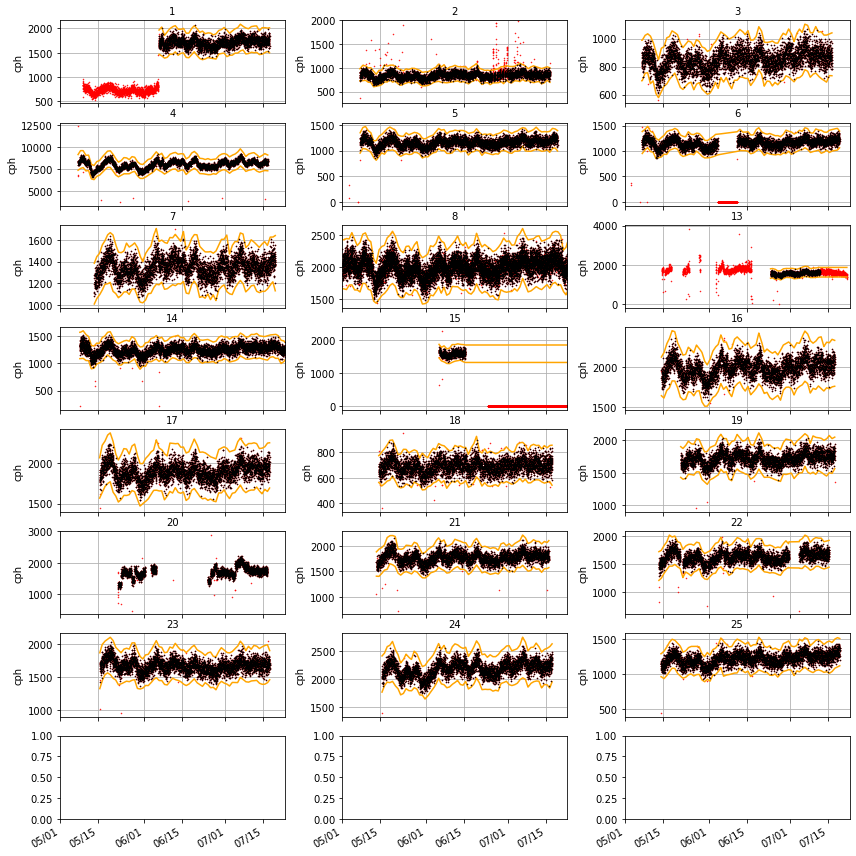

In [68]:
plt.rc('font', **{'size'   : 10})
fig, ax = plt.subplots(nrows=8, ncols=3, figsize=(12,12), sharex=True)
ax = ax.ravel()

xlim = dt.datetime(2019,5,1), dt.datetime(2019,7,23)#max_dtime

for i, key in enumerate(crns.keys()):
    ax[i].plot(crns[key].index, crns[key].cph1, linestyle="None", marker=".", ms=1, color="red")
    if not key==20:
        ax[i].plot(crns[key].index, crns[key].cph1_maxfilter, linestyle="-", ms=0, color="orange")
        ax[i].plot(crns[key].index, crns[key].cph1_minfilter, linestyle="-", ms=0, color="orange")
    ax[i].plot(crns[key].index, crns[key].cph1_filtered, linestyle="None", marker=".", ms=1, color="black")
    ax[i].set_title(key, fontsize=10)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("cph")
    ax[i].set_xlim(xlim)
    if key==2:
        ax[i].set_ylim(250,2000)
    #ax[i].set_ylim(pars[key]["mincph"], pars[key]["maxcph"]+200)
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax[i].grid()
    #ax[i].legend()    

fig.autofmt_xdate()    
plt.tight_layout(h_pad=0.1)

#plt.savefig("crns_raw.png", dpi=150, bbox_inches="tight")

## Export data

In [69]:
for i, id in enumerate(crns.keys()):
    if not "datetime" in crns[id].columns:
        crns[id].insert(loc=1, column="datetime", value=crns[id].index)
    if "cph1_maxfilter" in crns[id].columns:
        del crns[id]["cph1_maxfilter"]
    if "cph1_minfilter" in crns[id].columns:
        del crns[id]["cph1_minfilter"]
    if "cph1" in crns[id].columns:
        del crns[id]["cph1"]
    if "cph2" in crns[id].columns:
        del crns[id]["cph2"]
    if "Pv2.5_1" in crns[id].columns:
        crns[id] = crns[id][[c for c in crns[id] if c not in ["Pv2.5_1"]] + ["Pv2.5_1"]]
    crns[id]["counts1"] = crns[id]["counts1"].astype("i4")
    crns[id]["nsecs1"] = crns[id]["nsecs1"].astype("i4")
    if "counts2" in crns[id].columns: 
        crns[id]["counts2"] = crns[id]["counts2"].astype("i4")
        crns[id]["nsecs2"] = crns[id]["nsecs2"].astype("i4")
    crns[id]["volt"] = round(crns[id]["volt"],1)
    crns[id]["moder_cph_filt"] = round(crns[id]["cph1_filtered"],1)
    del crns[id]["cph1_filtered"]
    if "temp_ext" in crns[id].columns:
        crns[id].loc[crns[id].temp_ext <= 0, "temp_ext"] = np.nan
    if id==3:
        del crns[id]["temp_ext"]
    if id==13:
        del crns[id]["rec_id"]
        crns[id].columns = ["datetime","counts1","nsecs1","press1","temp_ext","relhum_ext","volt","hv","temp_ncat","moder_cph_filt"]
        crns[id]["press1"] = np.round(crns[id]["press1"]/100., 1)
        crns[id]["temp_ncat"] = round(crns[id]["temp_ncat"],1)
    if "relhum_ext" in crns[id].columns:
        crns[id]["relhum_ext"] = round(crns[id]["relhum_ext"],1)
    if "temp_ext" in crns[id].columns:
        crns[id]["temp_ext"] = round(crns[id]["temp_ext"],1)    
    for column in crns[id].columns[2:]:
        if column in ["counts1", "counts2", "nsecs1", "nsecs2"]:
            continue
        crns[id].loc[crns[id][column] == -99, column] = np.nan
    crns[id]["datetime"] = [dtime.strftime("%Y-%m-%dT%H:%M:%SZ") for dtime in pd.to_datetime(crns[id]["datetime"], format="%Y-%m-%d %H:%M:%S")]
    fpath = os.path.join(publishdir, "crns_data_%d.txt" % id )
    crns[id].to_csv(fpath, sep="\t", index=False, na_rep="nan", date_format="%Y-%m-%d %H:%M:%S")
    print(id)

1
2
3
4
5
6
7
8
13
14
15
16
17
18
19
20
21
22
23
24
25


### Remaining Styx

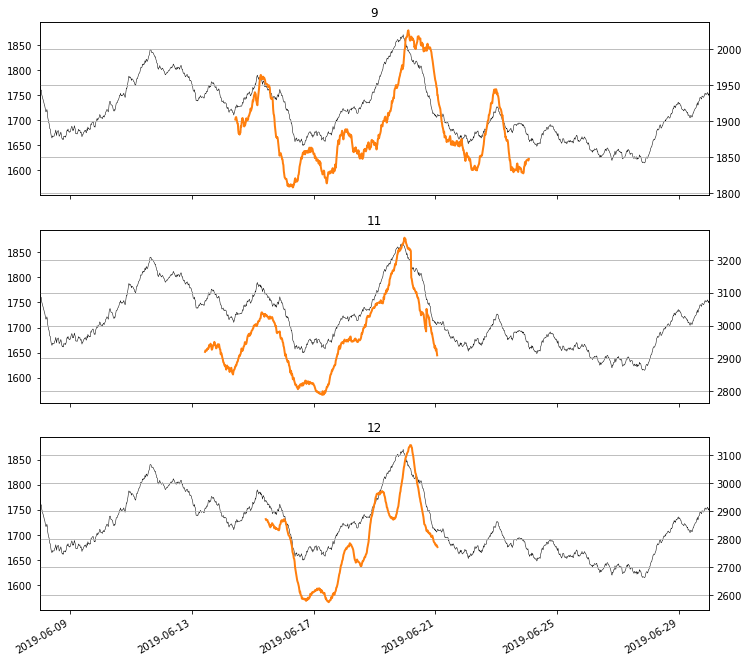

In [70]:
fnames = ["/media/x/cosmicsense/data/fendt/crns/sty_reproc/20200110/StyX9allCountSensorData3.dat", 
          "/media/x/cosmicsense/data/fendt/crns/sty_reproc/20200110/StyX11allCountSensorData4.dat",
          "/media/x/cosmicsense/data/fendt/crns/sty_reproc/20200110/StyX12allCountSensorData5.dat"]

fig, ax = plt.subplots(figsize=(12, 12), nrows=3)
ax = ax.ravel()
tmp = crns[19].rolling("12H", min_periods=3*12-5).mean()

for i, id in enumerate([9,11,12]):
    df = pd.read_csv(fnames[i], sep="\t", header=None)
    df.columns = ["datetime", "counts1", "nsecs1", "rec_id"]
    df.datetime = [dt.datetime.fromtimestamp(dtime) for dtime in  df.datetime]
    df = df.set_index("datetime")
    df.insert(loc=0, column="datetime", value=df.index)
    df = df[["datetime", "counts1", "nsecs1"]]
    df["moder_cph_filt"] = 3600 * df["counts1"] / df["nsecs1"]
    df = df[:"2019-07-20"]
    if id==9:
        df.loc["2019-06-24":, "moder_cph_filt"] = np.nan
        df.loc[:"2019-06-13", "moder_cph_filt"] = np.nan
    if id==11:
        df.loc["2019-06-21":, "moder_cph_filt"] = np.nan
        df.loc[:"2019-06-12", "moder_cph_filt"] = np.nan
    if id==12:
        df.loc["2019-06-21":, "moder_cph_filt"] = np.nan
        df.loc[:"2019-06-14", "moder_cph_filt"] = np.nan
    df["datetime"] = [dtime.strftime("%Y-%m-%dT%H:%M:%SZ") for dtime in pd.to_datetime(df["datetime"], format="%Y-%m-%d %H:%M:%S")]
    outpath = os.path.join(publishdir, "crns_data_%d.txt" % id )
    df.to_csv(outpath, sep="\t", index=False, date_format="%Y-%m-%d %H:%M:%S", na_rep="nan")
    
    tmpst = df.rolling("12H", min_periods=3*12-5).mean()
    plt.sca(ax[i])
    plt.plot(tmp.index, tmp.moder_cph_filt, color="black", lw=0.5, label="#4")
    ax2 = plt.twinx(ax[i])
    plt.sca(ax2)
    plt.plot(tmpst.index, tmpst.moder_cph_filt, color="tab:orange", lw=2)
    plt.title(str(id))
    plt.grid()
    plt.xlim(dt.datetime(2019,6,8), dt.datetime(2019,6,30))
    fig.autofmt_xdate()

In [71]:
styx10re = pd.read_csv("/media/x/cosmicsense/data/fendt/crns/sty_reproc/20200117/StyX10_allSensorDataN1_corr.dat",
                       sep="\t")
#UTC; counts; interval [s]; pressure [mbar]; temperature [°C]; rel. humidity [%]; V_Bat [V]; HV [V]; nCat_temperature [°C]; file number; counts with exponential correction; counts with quadratic correction
styx10re.columns = ["datetime", "counts1", "nsecs1", "press1", "temp_ext", "relhum_ext", "volt", "hv", "temp_ncat", "rec_id", "correxp", "corrquad"]
styx10re.datetime = [dt.datetime.fromtimestamp(dtime) for dtime in  styx10re.datetime]
styx10re = styx10re.set_index("datetime")
styx10re.insert(loc=0, column="counts_logged", value=styx10re["counts1"])
styx10re["counts1"] = styx10re["correxp"]
styx10re["press1"] = np.round(styx10re["press1"] / 100.,1)
styx10re["temp_ext"] = np.round(styx10re["temp_ext"],1)
styx10re["relhum_ext"] = np.round(styx10re["relhum_ext"],1)
styx10re["volt"] = np.round(styx10re["volt"],1)
styx10re.insert(loc=0, column="datetime", value=styx10re.index)
del styx10re["corrquad"]
del styx10re["correxp"]
del styx10re["rec_id"]
styx10re["moder_cph_filt"] = 3600 * styx10re["counts1"] / styx10re["nsecs1"]
styx10re.loc[:"2019-06-05 00:00:00","moder_cph_filt"] = np.nan
styx10re.loc["2019-06-11":"2019-06-27 00:00:00","moder_cph_filt"] = np.nan
styx10re.loc["2019-07-03' 00:00:00":,"moder_cph_filt"] = np.nan
styx10re["datetime"] = [dtime.strftime("%Y-%m-%dT%H:%M:%SZ") for dtime in pd.to_datetime(styx10re["datetime"], format="%Y-%m-%d %H:%M:%S")]
fpath = os.path.join(publishdir, "crns_data_10.txt")
styx10re.to_csv(fpath, sep="\t", index=False, na_rep="nan", date_format="%Y-%m-%d %H:%M:%S")

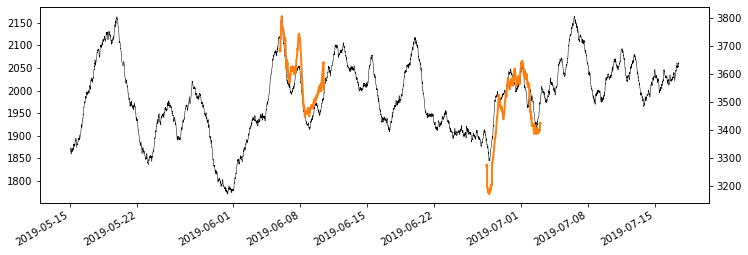

In [72]:
fig, ax = plt.subplots(figsize=(12, 4))
tmp4 = crns[4].rolling("12H", min_periods=3*12-5).mean()
tmp = crns[16].rolling("12H", min_periods=3*12-5).mean()
tmp10 = styx10re.rolling("12H", min_periods=3*12-5).mean()
#tmp3 = styx13re["2019-06-20":].rolling("24H", min_periods=3*24-5).mean()
#tmp = crns20.rolling("24H").mean()
#tmp.loc[:"2019-06-17",10] = np.nan
#plt.plot(tmp4.index, tmp4.moder_cph_filt, color="black", lw=0.5, label="#4")
plt.plot(tmp.index, tmp.moder_cph_filt, color="black", lw=0.5, label="#4")
#plt.xlim(dt.datetime(2019,6,24), dt.datetime(2019,7,20))
#plt.fill_between(np.array([dt.datetime(2019,6,25,8), dt.datetime(2019,6,26,18)]),
#                 ylim[0]-50, ylim[1]+50, color="tab:red", alpha=0.3, zorder=-1)
#plt.axvline(rovcal.loc[id, "time"], color="tab:red", ls="--")
ax2 = plt.twinx(ax)
plt.sca(ax2)
#tmp10.loc[:"2019-06-27"] = np.nan
#tmp10.loc["2019-07-05":] = np.nan
plt.plot(tmp10.index, tmp10.moder_cph_filt, color="tab:orange", lw=2)
#plt.ylim(2400, 4000)
fig.autofmt_xdate()


### Export table

In [73]:
header = """# Attributes of CRNS stations
# ---------------------------
# id: CRNS station ID from 1 to 25
# lon: longitude, in decimal degrees (EPSG: 4326)
# lat: latitude, in decimal degrees (EPSG: 4326)
# type: type/manufacturer of CRNS detector unit
# institution: member of the Cosmic Sense consortium that owns the CRNS unit
# sensitivity: sensitivity of the detector for epithermal neutrons relative to CRNS unit #20 (calibrator)
# calstart: datetime at which the collocation of the calibrator CRNS (#20) started
# calend: datetime at which the collocation of the calibrator CRNS (#20) ended
"""

In [74]:
attrs2 = attrs[["lon", "lat", "type", "institution", "sensitivity", "calstart", "calend"]]
attrs2.lon = np.round(attrs2.lon, 6)
attrs2.lat = np.round(attrs2.lat, 6)
attrs2.loc[attrs2.lat==-9999, "lat"] = np.nan
attrs2.loc[attrs2.lon==-9999, "lon"] = np.nan
attrs2["calstart"] = [dtime.strftime("%Y-%m-%dT%H:%M:%SZ") for dtime in pd.to_datetime(attrs2.calstart, format="%Y-%m-%d %H:%M:%S")]
attrs2["calend"] = [dtime.strftime("%Y-%m-%dT%H:%M:%SZ") for dtime in pd.to_datetime(attrs2.calend, format="%Y-%m-%d %H:%M:%S")]
attrs2.loc[attrs2.calstart=="1900-01-01T00:00:00Z", "calstart"] = "None"
attrs2.loc[attrs2.calend=="1900-01-01T00:00:00Z", "calend"] = "None"
attrs2.sensitivity = np.round(attrs2.sensitivity, 6)
attrs2.insert(loc=0, column="id", value=attrs.index)
attrs2.loc[attrs2.type=="Styx Neutronica", "type"] = "StX-140-5-15"
attrs2.loc[attrs2.type=="Lab-C", "type"] = "Lab-C NeuSens dual"
attrs2.loc[np.in1d(attrs2.id, [9,10,11,12]), "sensitivity"] = np.nan
fpath = os.path.join(publishdir, "crns_attributes.txt")
with open(fpath, "w") as f:
    f.write(header)
    attrs2.to_csv(f, sep="\t", index=False, na_rep="nan", date_format="%Y-%m-%d %H:%M:%S")
attrs2

/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

,id,lon,lat,type,institution,sensitivity,calstart,calend
id,,,,,,,,
1,1,11.064440,47.825350,CRS 2000-B,UP,1.190,None,None
2,2,11.061650,47.826560,CRS 1000,UP,0.452,None,None
3,3,11.059494,47.831677,CRS 1000,UP,0.458,None,None
4,4,11.061470,47.823910,Lab-C NeuSens dual,UP,4.530,2019-05-28T09:45:00Z,2019-05-29T09:25:00Z
5,5,11.063264,47.828784,CRS 1000-B,KIT,0.670,2019-05-29T12:20:00Z,2019-05-31T08:35:00Z
6,6,11.064510,47.822520,CRS 1000-B,KIT,0.668,None,None
7,7,11.059960,47.828184,CRS 1000-B,KIT,0.668,None,None
8,8,11.060487,47.832478,CRS 2000-B,KIT,1.161,2019-06-04T16:00:00Z,2019-06-05T11:53:00Z
9,9,11.066562,47.828935,StX-140-5-15,UFZ,NaN,2019-07-09T10:33:00Z,2019-07-10T13:08:00Z


In [75]:
1./np.sqrt(2000*24)

0.004564354645876384

In [76]:
attrs2

,id,lon,lat,type,institution,sensitivity,calstart,calend
id,,,,,,,,
1,1,11.064440,47.825350,CRS 2000-B,UP,1.190,None,None
2,2,11.061650,47.826560,CRS 1000,UP,0.452,None,None
3,3,11.059494,47.831677,CRS 1000,UP,0.458,None,None
4,4,11.061470,47.823910,Lab-C NeuSens dual,UP,4.530,2019-05-28T09:45:00Z,2019-05-29T09:25:00Z
5,5,11.063264,47.828784,CRS 1000-B,KIT,0.670,2019-05-29T12:20:00Z,2019-05-31T08:35:00Z
6,6,11.064510,47.822520,CRS 1000-B,KIT,0.668,None,None
7,7,11.059960,47.828184,CRS 1000-B,KIT,0.668,None,None
8,8,11.060487,47.832478,CRS 2000-B,KIT,1.161,2019-06-04T16:00:00Z,2019-06-05T11:53:00Z
9,9,11.066562,47.828935,StX-140-5-15,UFZ,NaN,2019-07-09T10:33:00Z,2019-07-10T13:08:00Z


## Remaing StyX version from 2020-02-26

9
10
11
12


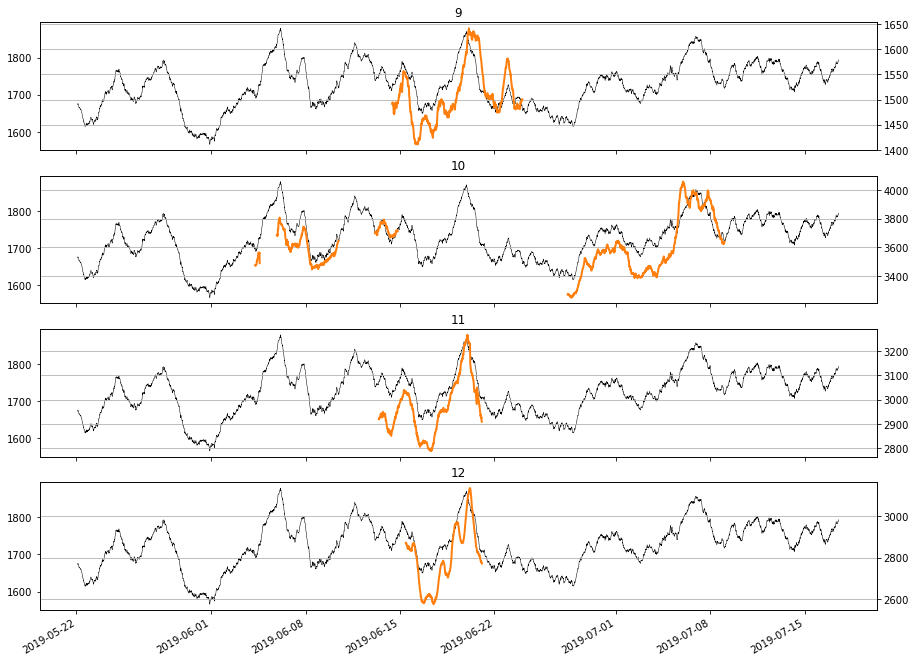

In [77]:
fnames = ["/media/x/cosmicsense/data/fendt/crns/sty_reproc/20200226/StyX9allCountSensorData_All_corr2.dat",
          "/media/x/cosmicsense/data/fendt/crns/sty_reproc/20200226/StyX10allCountSensorData_All_corr.dat",
          "/media/x/cosmicsense/data/fendt/crns/sty_reproc/20200226/StyX11allCountSensorData4_All.dat",
          "/media/x/cosmicsense/data/fendt/crns/sty_reproc/20200226/StyX12allCountSensorData5_All.dat"]

fig, ax = plt.subplots(figsize=(15, 12), nrows=4)
ax = ax.ravel()
tmp = crns[19].rolling("12H", min_periods=3*12-5).mean()
cols = ["datetime", "counts1", "nsecs1", "press1", "temp_ext", "relhum_ext", "volt", "hv", "temp_ncat", "rec_id"]

for i, id in enumerate([9,10,11,12]):
    print(id)
    try:
        df = pd.read_csv(fnames[i], sep="\t", header=None)
        #df.columns = ["datetime", "counts1", "nsecs1", "rec_id"]
        df.columns = cols
    except ValueError:
        df = pd.read_csv(fnames[i], sep=";", header=None)
        #df.columns = ["datetime", "counts1", "nsecs1", "rec_id"]
        df.columns = cols        
    df.datetime = [dt.datetime.fromtimestamp(dtime) for dtime in  df.datetime]
    df = df.set_index("datetime")
    df.insert(loc=0, column="datetime", value=df.index)
    df["counts1"] = np.round(df["counts1"], 1)
    df["press1"] = np.round(df["press1"] / 100.,1)
    df["temp_ext"] = np.round(df["temp_ext"],1)
    df["relhum_ext"] = np.round(df["relhum_ext"],1)
    df["volt"] = np.round(df["volt"],1)
    df = df[["datetime", "counts1", "nsecs1", "press1", "temp_ext", "relhum_ext", "volt", "hv", "temp_ncat"]]
    df["moder_cph_filt"] = np.round(3600. * df["counts1"] / df["nsecs1"], 1)
    df = df[:"2019-07-20"]
    if id==9:
        df.loc["2019-06-24":, "moder_cph_filt"] = np.nan
        df.loc[:"2019-06-13", "moder_cph_filt"] = np.nan
    if id==10:
        df.loc["2019-06-24":"2019-06-26", "moder_cph_filt"] = np.nan
        df.loc["2019-07-09":, "moder_cph_filt"] = np.nan
    if id==11:
        df.loc["2019-06-21":, "moder_cph_filt"] = np.nan
        df.loc[:"2019-06-12", "moder_cph_filt"] = np.nan
    if id==12:
        df.loc["2019-06-21":, "moder_cph_filt"] = np.nan
        df.loc[:"2019-06-14", "moder_cph_filt"] = np.nan
    df["datetime"] = [dtime.strftime("%Y-%m-%dT%H:%M:%SZ") for dtime in pd.to_datetime(df["datetime"], format="%Y-%m-%d %H:%M:%S")]
    outpath = os.path.join(publishdir, "crns_data_%d.txt" % id )
    df.to_csv(outpath, sep="\t", index=False, date_format="%Y-%m-%d %H:%M:%S", na_rep="nan")
    
    tmpst = df.rolling("12H", min_periods=3*12-5).mean()
    plt.sca(ax[i])
    plt.plot(tmp.index, tmp.moder_cph_filt, color="black", lw=0.5, label="#4")
    ax2 = plt.twinx(ax[i])
    plt.sca(ax2)
    plt.plot(tmpst.index, tmpst.moder_cph_filt, color="tab:orange", lw=2)
    plt.title(str(id))
    plt.grid()
    #plt.xlim(dt.datetime(2019,6,8), dt.datetime(2019,6,30))
    fig.autofmt_xdate()